<a href="https://colab.research.google.com/github/grusnyeglaza/digital_image_processing/blob/main/HW_1_Kaggle_house.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Загрузка библиотек.

In [ ]:
%pip install pandas>=2.1
%pip install numpy>=1.25.0
%pip install d2l
%pip install kaggle
%matplotlib inline
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

Загрузка данных.

In [ ]:
def download(url, folder, sha1_hash=None):
    """Download a file to folder and return the local filepath."""

def extract(filename, folder):
    """Extract a zip/tar file into folder."""

Доступ к набору данных и его чтение.

In [ ]:
class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

Обучающий набор данных включает 1460 примеров, 80 признаков и одну метку, тогда как проверочные данные содержат 1459 примеров и 80 признаков.

In [ ]:
data = KaggleHouse(batch_size=64)
print(data.raw_train.shape)
print(data.raw_val.shape)

(1460, 81)
(1459, 80)


Предварительная обработка данных.

In [ ]:
print(data.raw_train.iloc[:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


In [ ]:
@d2l.add_to_class(KaggleHouse)
def preprocess(self):
    # Remove the ID and label columns
    label = 'SalePrice'
    features = pd.concat(
        (self.raw_train.drop(columns=['Id', label]),
         self.raw_val.drop(columns=['Id'])))
    # Standardize numerical columns
    numeric_features = features.dtypes[features.dtypes!='object'].index
    features[numeric_features] = features[numeric_features].apply(
        lambda x: (x - x.mean()) / (x.std()))
    # Replace NAN numerical features by 0
    features[numeric_features] = features[numeric_features].fillna(0)
    # Replace discrete features by one-hot encoding
    features = pd.get_dummies(features, dummy_na=True)
    # Save preprocessed features
    self.train = features[:self.raw_train.shape[0]].copy()
    self.train[label] = self.raw_train[label]
    self.val = features[self.raw_train.shape[0]:].copy()

In [ ]:
data.preprocess()
data.train.shape

(1460, 331)

Погрешность измерения.

In [ ]:
@d2l.add_to_class(KaggleHouse)
def get_dataloader(self, train):
    label = 'SalePrice'
    data = self.train if train else self.val
    if label not in data: return
    get_tensor = lambda x: torch.tensor(x.values.astype(float),
                                      dtype=torch.float32)
    # Logarithm of prices
    tensors = (get_tensor(data.drop(columns=[label])),  # X
               torch.log(get_tensor(data[label])).reshape((-1, 1)))  # Y
    return self.get_tensorloader(tensors, train)

К-перекрестная проверка свертывания.

In [ ]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets

In [ ]:
def k_fold(trainer, data, k, lr):
    val_loss, models = [], []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = d2l.LinearRegression(lr)
        model.board.yscale='log'
        if i != 0: model.board.display = False
        trainer.fit(model, data_fold)
        val_loss.append(float(model.board.data['val_loss'][-1].y))
        models.append(model)
    print(f'average validation log mse = {sum(val_loss)/len(val_loss)}')
    return models

Выбор модели.

average validation log mse = 0.1787834715843201


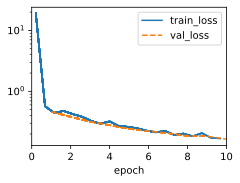

In [ ]:
trainer = d2l.Trainer(max_epochs=10)
models = k_fold(trainer, data, k=5, lr=0.01)

Отправка прогнозов на Kaggle https://www.kaggle.com/c/house-prices-advanced-regression-techniques

In [ ]:
preds = [model(torch.tensor(data.val.values.astype(float), dtype=torch.float32))
         for model in models]
# Taking exponentiation of predictions in the logarithm scale
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id':data.raw_val.Id,
                           'SalePrice':ensemble_preds.detach().numpy()})
submission.to_csv('submission.csv', index=False)



---


**1** Отправьте свои прогнозы для этого раздела на Kaggle. Насколько они хороши?



---



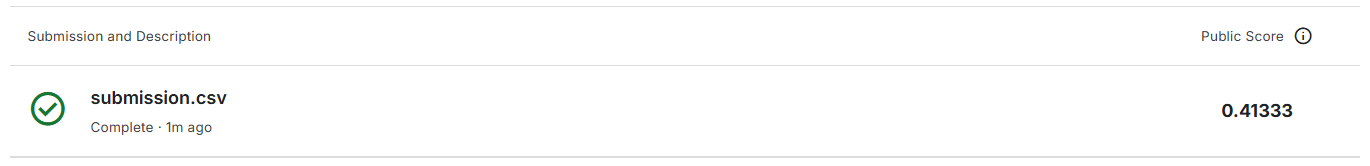



---


**2** Всегда ли хорошая идея заменить пропущенные значения средним значением?


---



Невсегда так можно делать. Иногда замена средним значением может искажать данные.







---


**3** Улучшить оценку, настроив гиперпараметры с помощью K-кратная
перекрестная проверка.



---


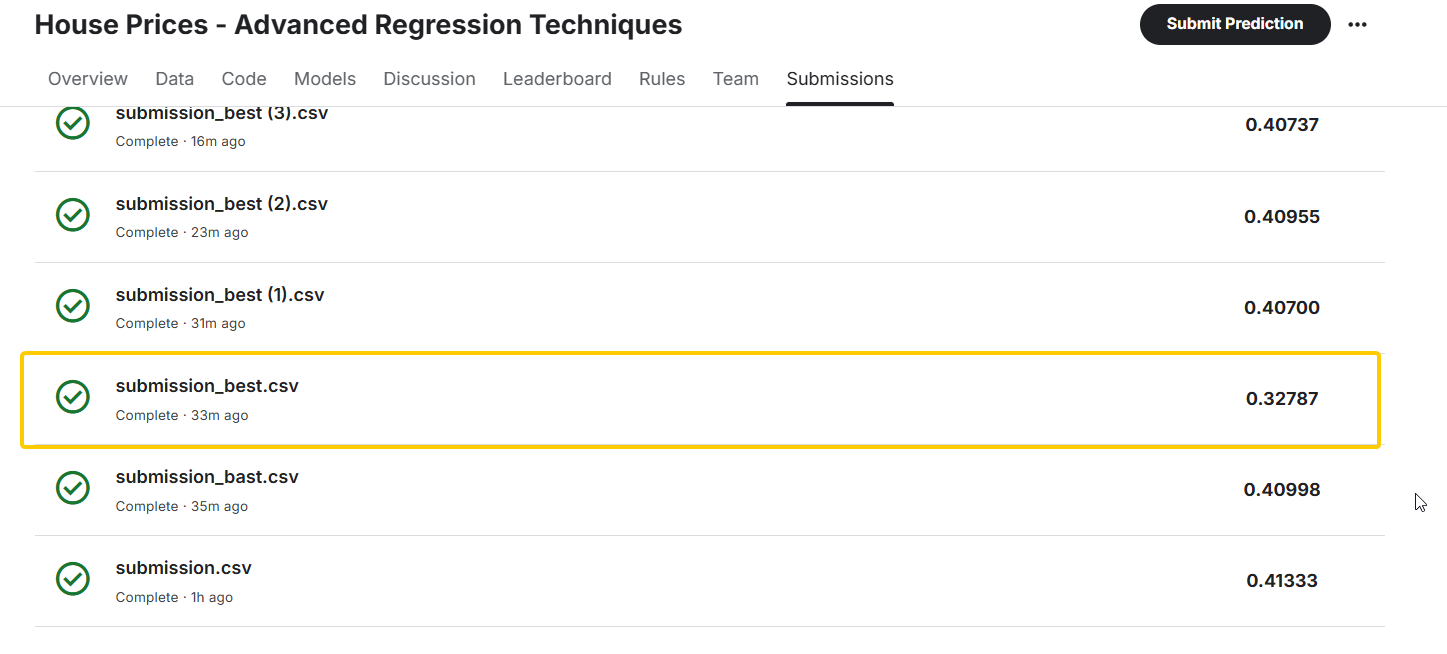



---


**4** Улучшите оценку, улучшив модель (например, слои, снижение веса и
отсев).


---



In [ ]:
def download(url, folder, sha1_hash=None):
    """Download a file to folder and return the local filepath."""

def extract(filename, folder):
    """Extract a zip/tar file into folder."""

class KaggleHouse(d2l.DataModule):
    def __init__(self, batch_size, train=None, val=None):
        super().__init__()
        self.save_hyperparameters()
        if self.train is None:
            self.raw_train = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_train.csv', self.root,
                sha1_hash='585e9cc93e70b39160e7921475f9bcd7d31219ce'))
            self.raw_val = pd.read_csv(d2l.download(
                d2l.DATA_URL + 'kaggle_house_pred_test.csv', self.root,
                sha1_hash='fa19780a7b011d9b009e8bff8e99922a8ee2eb90'))

    def preprocess(self):
        label = 'SalePrice'
        features = pd.concat(
            (self.raw_train.drop(columns=['Id', label]),
             self.raw_val.drop(columns=['Id'])))
        numeric_features = features.dtypes[features.dtypes != 'object'].index
        features[numeric_features] = features[numeric_features].apply(
            lambda x: (x - x.mean()) / (x.std()))
        features[numeric_features] = features[numeric_features].fillna(0)
        features = pd.get_dummies(features, dummy_na=True)
        self.train = features[:self.raw_train.shape[0]].copy()
        self.train[label] = self.raw_train[label]
        self.val = features[self.raw_train.shape[0]:].copy()

    def get_dataloader(self, train):
        label = 'SalePrice'
        data = self.train if train else self.val
        if label not in data: return
        get_tensor = lambda x: torch.tensor(x.values.astype(float), dtype=torch.float32)
        tensors = (get_tensor(data.drop(columns=[label])),
                   torch.log(get_tensor(data[label])).reshape((-1, 1)))
        return self.get_tensorloader(tensors, train)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_prob):
        super(MLP, self).__init__()
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.hidden(x))
        x = self.dropout(x)
        x = self.output(x)
        return x


In [ ]:
def k_fold_data(data, k):
    rets = []
    fold_size = data.train.shape[0] // k
    for j in range(k):
        idx = range(j * fold_size, (j+1) * fold_size)
        rets.append(KaggleHouse(data.batch_size, data.train.drop(index=idx),
                                data.train.loc[idx]))
    return rets

def k_fold(trainer, data, k, lr, weight_decay, dropout_prob):
    val_loss = []
    models = []
    for i, data_fold in enumerate(k_fold_data(data, k)):
        model = MLP(input_dim=data.train.shape[1] - 1, hidden_dim=256, output_dim=1, dropout_prob=dropout_prob)
        def init_weights(m):
            if type(m) == nn.Linear:
                nn.init.xavier_uniform_(m.weight)
        model.apply(init_weights)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.MSELoss()
        for epoch in range(trainer.max_epochs):
            for batch in data_fold.get_dataloader(train=True):
                X, y = batch
                optimizer.zero_grad()
                output = model(X)
                loss = criterion(output, y)
                loss.backward()
                optimizer.step()
            val_loss_epoch = 0
            with torch.no_grad():
                for val_batch in data_fold.get_dataloader(train=False):
                    X_val, y_val = val_batch
                    val_output = model(X_val)
                    val_loss_epoch += criterion(val_output, y_val).item()
            val_loss_epoch /= len(data_fold.get_dataloader(train=False))
            val_loss.append(val_loss_epoch)
        models.append(model)
    avg_val_loss = sum(val_loss) / len(val_loss)
    print(f'average validation log mse = {avg_val_loss}')
    return models, val_loss


In [ ]:
learning_rates = [0.01, 0.001, 0.0001]
weight_decays = [0.001, 0.01, 0.1]
dropout_probs = [0.2, 0.5]

In [ ]:
best_lr = None
best_weight_decay = None
best_dropout_prob = None
best_val_loss = float('inf')

for lr in learning_rates:
    for weight_decay in weight_decays:
        for dropout_prob in dropout_probs:
            trainer = d2l.Trainer(max_epochs=10)
            data = KaggleHouse(batch_size=64)
            data.preprocess()
            models, val_loss = k_fold(trainer, data, k=5, lr=lr, weight_decay=weight_decay, dropout_prob=dropout_prob)
            avg_val_loss = sum(val_loss) / len(val_loss)
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_lr = lr
                best_weight_decay = weight_decay
                best_dropout_prob = dropout_prob

print(f'Best learning rate: {best_lr}')
print(f'Best weight decay: {best_weight_decay}')
print(f'Best dropout probability: {best_dropout_prob}')


average validation log mse = 1.2286239238977432
average validation log mse = 2.778066005706787
average validation log mse = 1.2654951775074006
average validation log mse = 2.8247752628326417
average validation log mse = 1.2944223536252975
average validation log mse = 2.50618652009964
average validation log mse = 1.4054124141335484
average validation log mse = 2.851065946340561
average validation log mse = 0.9815013867616655
average validation log mse = 2.3210721030235293
average validation log mse = 1.2558492345809935
average validation log mse = 3.035240360260009
average validation log mse = 52.65395232200623
average validation log mse = 52.935619186401375
average validation log mse = 54.25224800491333
average validation log mse = 52.77215278816221
average validation log mse = 51.176704037666305
average validation log mse = 56.052749420166016
Best learning rate: 0.001
Best weight decay: 0.01
Best dropout probability: 0.2


In [ ]:
trainer = d2l.Trainer(max_epochs=10)
data = KaggleHouse(batch_size=64)
data.preprocess()
models, _ = k_fold(trainer, data, k=5, lr=best_lr, weight_decay=best_weight_decay, dropout_prob=best_dropout_prob)



average validation log mse = 1.0888427511453627


In [ ]:
preds = [model(torch.tensor(data.val.values.astype(float), dtype=torch.float32))
         for model in models]
ensemble_preds = torch.exp(torch.cat(preds, 1)).mean(1)
submission = pd.DataFrame({'Id': data.raw_val.Id,
                           'SalePrice': ensemble_preds.detach().numpy()})
submission.to_csv('submission_ves_pomenshe.csv', index=False)

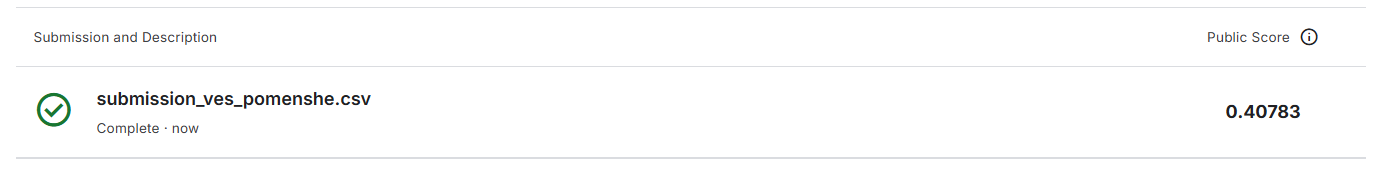



---

**5** Что произойдет, если мы не стандартизируем непрерывные числовые характеристики, как мы сделали в этом разделе?


---



Алгоритмы градиентного спуска будут сходиться медленнее или не сойдутся.